In [40]:
import pandas as pd
import numpy as np

from Dates import from_excel_date, bump_date

In [41]:
spot = pd.read_excel('data/FX.xlsx', index_col=0)
spot.index.rename('Date', inplace=True)
spot.drop('Date',inplace=True)
spot.index = spot.index.map(from_excel_date)
spot.dropna(inplace=True)
spot.tail()

,MXN,BRL,COP,CLP,PEN
Date,,,,,
2025-12-24,17.9432,5.5225,3736.55,904.39,3.371
2025-12-26,17.9115,5.5436,3703.99,907.06,3.3679
2025-12-29,17.9794,5.5724,3742.07,915.23,3.3668
2025-12-30,17.9952,5.4753,3775.5,899.95,3.363
2025-12-31,18.008,5.4956,3774.72,900.58,3.3621


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================

# OPTION A: If loading from your CSV (Uncomment and use this)
# ---------------------------------------------------------
# spot = pd.read_csv('your_data.csv')

# # Check if 'Date' exists as a column and set it as index
# if 'Date' in spot.columns:
#     spot['Date'] = pd.to_datetime(spot['Date'])
#     spot.set_index('Date', inplace=True)

# OPTION B: Generate Dummy Data (For testing right now)
# ---------------------------------------------------------
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', end='2025-12-31', freq='B')
# Simulate different vols: BRL/COP (High), MXN (Med), PEN (Low)
vols = {'USDMXN': 0.12, 'USDCOP': 0.15, 'USDCLP': 0.14, 'USDBRL': 0.16, 'USDPEN': 0.08}
spot_data = {}

for pair, vol in vols.items():
    # Geometric Brownian Motion simulation
    returns = np.random.normal(0, vol/np.sqrt(252), len(dates))
    price_path = 100 * np.exp(np.cumsum(returns))
    spot_data[pair] = price_path

spot = pd.DataFrame(spot_data, index=dates)

# ==========================================
# 2. ROBUST PRE-PROCESSING (The Fix)
# ==========================================

# 1. Force all data to numeric (coerces errors to NaN)
spot = spot.apply(pd.to_numeric, errors='coerce')

# 2. Drop rows that contain any NaNs (cleaning bad data points)
spot.dropna(inplace=True)

# 3. Calculate Log Returns
# We use .astype(float) to ensure numpy treats them as numbers
returns = np.log(spot.astype(float) / spot.astype(float).shift(1)).dropna()

print(f"Data Cleaned. Returns Shape: {returns.shape}")
print(f"Pairs included: {list(returns.columns)}")

# ==========================================
# 3. CALCULATE DISPERSION METRICS
# ==========================================

# Define Weights (Equal Weight 20% each)
n_assets = len(returns.columns)
weights = np.ones(n_assets) / n_assets

# A. Create Synthetic Index Return
returns['Index'] = returns.dot(weights)

# Parameters
window = 63   # 3 Months (~Quarterly)
ann_factor = 252

# B. Calculate Rolling Realized Volatility
rolling_vol = returns.rolling(window=window).std() * np.sqrt(ann_factor)

# C. Calculate Dispersion Spread (The "Alpha")
# Spread = Average(Component Variance) - Index Variance
avg_component_var = (rolling_vol.drop('Index', axis=1)**2).mean(axis=1)
index_var = rolling_vol['Index']**2
dispersion_spread = avg_component_var - index_var

# D. Calculate Average Pairwise Correlation
def get_avg_corr(window_data):
    if window_data.shape[0] < window: return np.nan
    corr_mat = window_data.corr()
    # Mask diagonal to ignore self-correlation (which is always 1)
    mask = np.ones_like(corr_mat, dtype=bool)
    np.fill_diagonal(mask, False)
    return corr_mat[mask].mean()


Data Cleaned. Returns Shape: (1565, 5)
Pairs included: ['USDMXN', 'USDCOP', 'USDCLP', 'USDBRL', 'USDPEN']


<Axes: title={'center': 'Correlation'}>

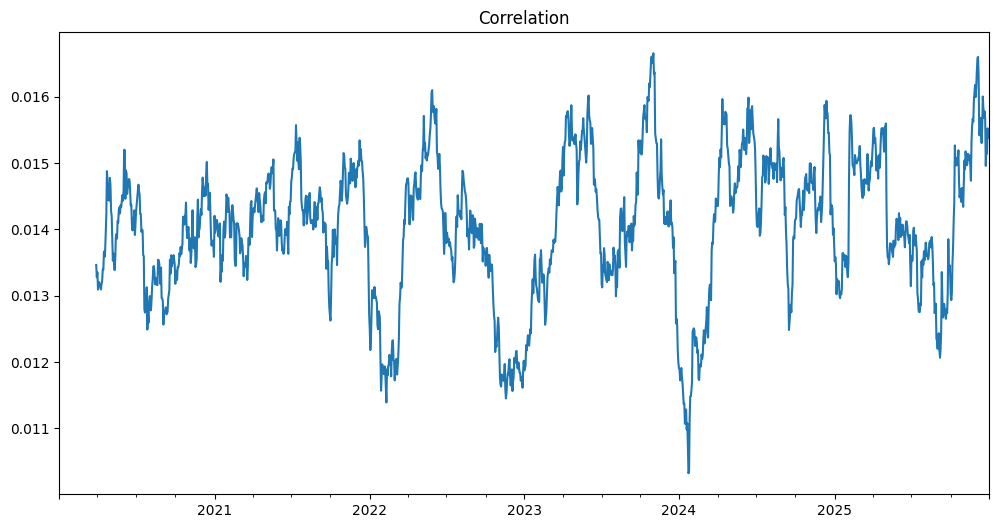

In [ ]:
dispersion_spread.plot(figsize=(12,6), title = f'Correlation')
(index_var/avg_component_var).plot(figsize=(12,6))

<Axes: >

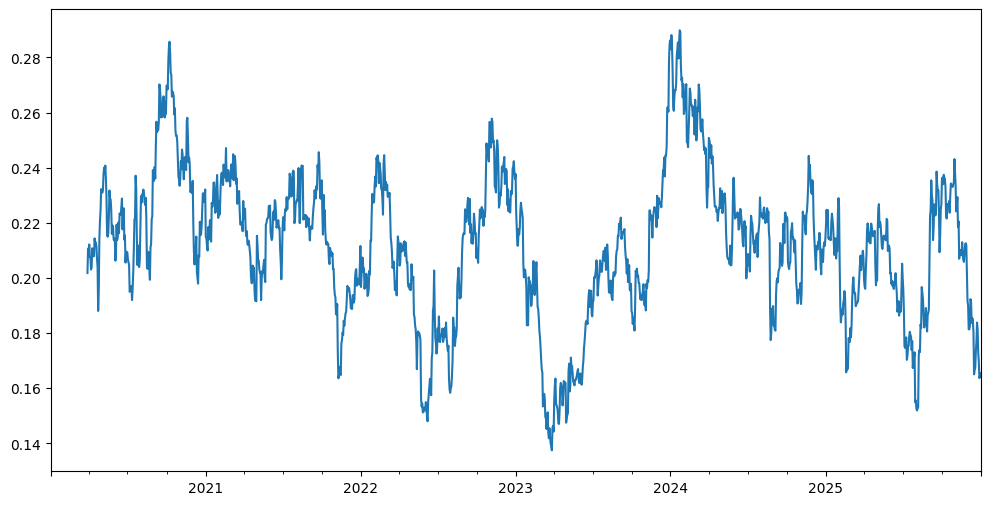

In [57]:
# E. Calculate Absorption Ratio (PCA - Systemic Risk)
def get_pc1_variance(window_data):
    if window_data.shape[0] < window: return np.nan
    # Standardize data for PCA
    data_std = (window_data - window_data.mean()) / window_data.std()
    pca = PCA(n_components=1)
    pca.fit(data_std)
    return pca.explained_variance_ratio_[0]

rolling_pc1 = returns.drop('Index', axis=1).rolling(window=window).apply(get_pc1_variance, raw=False)

# ==========================================
# 4. VISUALIZATION
# ==========================================

# Set style (optional)
plt.style.use('bmh')

fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

# Plot 1: Dispersion Spread (Profitability Proxy)
axes[0].plot(dispersion_spread, color='darkgreen', lw=1.5)
axes[0].set_title('1. Feasibility: Realized Dispersion Spread (Avg Var - Index Var)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Variance Spread')
axes[0].axhline(dispersion_spread.mean(), color='black', linestyle='--', alpha=0.5, label='Mean Spread')
axes[0].legend()

# Plot 2: Correlation vs Volatility (The "Jaws")
ax2 = axes[1]
ax2_right = ax2.twinx()
ax2.plot(rolling_corr, color='firebrick', label='Avg Pairwise Corr', lw=1.5)
ax2_right.fill_between(rolling_vol.index, 0, rolling_vol['Index'], color='navy', alpha=0.15, label='Index Vol')
ax2.set_title('2. Opportunity Check: Correlation vs. Index Volatility', fontsize=12, fontweight='bold')
ax2.set_ylabel('Avg Correlation', color='firebrick')
ax2_right.set_ylabel('Annualized Vol', color='navy')

# Plot 3: PCA Absorption (Systemic Risk)
axes[2].plot(rolling_pc1, color='purple', lw=1.5)
axes[2].set_title('3. Systemic Risk: Variance Explained by PC1 (Global Factor)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('% Variance')
axes[2].axhline(0.80, color='red', linestyle='--', alpha=0.7, label='High Systemic Risk (>80%)')
axes[2].axhline(0.50, color='green', linestyle='--', alpha=0.7, label='Idiosyncratic (>50%)')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [64]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def plot_rolling_correlations(spot_df, window=63):
    """
    Generates an interactive Plotly chart showing rolling correlations
    AND the average correlation of the anchor currency vs the basket.
    """
    
    # 1. Preprocessing: Clean and Calculate Log Returns
    df_clean = spot_df.apply(pd.to_numeric, errors='coerce').dropna()
    returns = np.log(df_clean / df_clean.shift(1)).dropna()
    assets = returns.columns.tolist()
    
    # 2. Pre-calculate Rolling Correlations
    # Structure: dict[anchor] -> dict[other] -> Series
    corr_data = {}
    for anchor in assets:
        corr_data[anchor] = {}
        for other in assets:
            if anchor == other: continue
            corr_data[anchor][other] = returns[anchor].rolling(window=window).corr(returns[other])

    # 3. Build Figure & Traces
    fig = go.Figure()
    
    # Track trace indices for the dropdown
    trace_indices = {asset: [] for asset in assets}
    current_trace_idx = 0
    
    colors = ['#EF553B', '#636EFA', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']
    
    for i, anchor in enumerate(assets):
        # We will collect all pair correlations for this anchor to calculate the average
        anchor_corrs = []
        
        # A. Add Individual Pair Traces
        color_idx = 0
        for other in assets:
            if anchor == other: continue
            
            series = corr_data[anchor][other]
            anchor_corrs.append(series)
            
            fig.add_trace(go.Scatter(
                x=returns.index,
                y=series,
                mode='lines',
                name=f"{other}", 
                line=dict(width=1.5, color=colors[color_idx % len(colors)]),
                visible=(i == 0),
                opacity=0.6, # Make individual lines slightly transparent
                hovertemplate=f"<b>{anchor} vs {other}</b><br>Corr: %{{y:.2f}}<extra></extra>"
            ))
            trace_indices[anchor].append(current_trace_idx)
            current_trace_idx += 1
            color_idx += 1
            
        # B. Add "Average Correlation" Trace (The new requirement)
        # Calculate row-wise mean of the collected series
        if anchor_corrs:
            avg_series = pd.concat(anchor_corrs, axis=1).mean(axis=1)
            
            fig.add_trace(go.Scatter(
                x=returns.index,
                y=avg_series,
                mode='lines',
                name=f"AVG {anchor} CORRELATION",
                line=dict(width=4, color='black', dash='dash'), # Thick, black, dashed
                visible=(i == 0),
                hovertemplate=f"<b>Avg {anchor} Correlation</b><br>%{{y:.2f}}<extra></extra>"
            ))
            trace_indices[anchor].append(current_trace_idx)
            current_trace_idx += 1

    # 4. Create Dropdown Menu
    buttons = []
    for anchor in assets:
        # Create visibility array
        visibility = [False] * current_trace_idx
        for idx in trace_indices[anchor]:
            visibility[idx] = True
            
        buttons.append(dict(
            label=anchor,
            method="update",
            args=[
                {"visible": visibility},
                {"title": f"Rolling {window}-Day Correlation: {anchor} (Black Line = Average)"}
            ]
        ))

    # 5. Final Layout
    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.0, xanchor="left",
            y=1.15, yanchor="top"
        )],
        title=f"Rolling {window}-Day Correlation: {assets[0]} (Black Line = Average)",
        yaxis=dict(title="Correlation Coefficient", range=[-1.1, 1.1]),
        template="plotly_white",
        height=600,
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, bgcolor="rgba(255,255,255,0.8)")
    )
    
    return fig

# ==========================================
# EXAMPLE USAGE
# ==========================================
# fig = plot_rolling_correlations(spot, window=63)
# fig.show()

In [77]:
import plotly.io as pio

# fig is your plotly.graph_objects.Figure or plotly.express figure


In [78]:
fig = plot_rolling_correlations(spot, window=63)
pio.write_html(fig, file="Correlations.html", auto_open=False, include_plotlyjs="cdn")

TypeError: unsupported operand type(s) for /: 'float' and 'Axes'

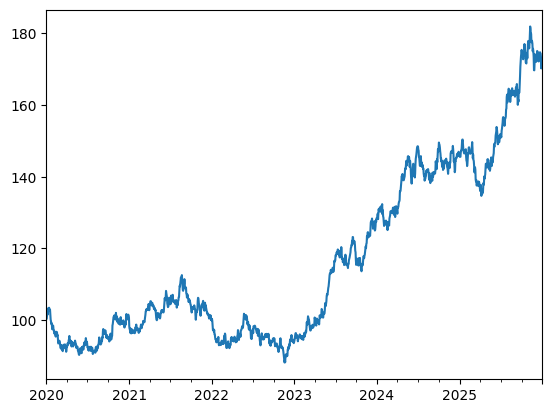

In [70]:
spot['USDBRL']/spot['USDMXN'].plot()